In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from transformers import AutoTokenizer, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/Users/bachirzerroug/Library/Caches/pypoetry/virtualenvs/transformers-implementation-xd7zxmCX-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/Users/bachirzerroug/Documents/transformers-implementation')

In [3]:
from src.local_transformers import Encoder
from src.utils import EarlyStopping, PreTrainedTokenizer

# Import data

In [4]:
tr_raw = pd.read_csv('src/data/transactions.csv')
tr_raw.columns = [col.lower() for col in tr_raw.columns]


In [5]:
tr_raw

,customer_id,tx_datetime,tx_amount,sector_id,tx_fraud
0,2541,2023-01-01 00:21:42,499.210846,11,False
1,1735,2023-01-01 00:21:59,58.824293,3,False
2,669,2023-01-01 00:36:40,91.967189,12,False
3,4235,2023-01-01 00:51:34,836.571053,16,False
4,2162,2023-01-01 01:15:23,1537.707662,19,False
...,...,...,...,...,...
1229916,3367,2023-06-18 13:37:35,1688.437989,19,False
1229917,488,2023-06-18 13:37:40,679.409104,8,False
1229918,292,2023-06-18 13:37:42,128.156666,2,False
1229919,2036,2023-06-18 13:37:42,953.330547,15,False


In [6]:
# Get datetime column
tr_raw['tx_datetime'] = pd.to_datetime(tr_raw['tx_datetime'])
df_tr = tr_raw.sort_values(by='tx_datetime', ascending=True)

# Convert True false to 0 and 1
df_tr['tx_fraud'] = df_tr['tx_fraud']*1

df_tr

,customer_id,tx_datetime,tx_amount,sector_id,tx_fraud
0,2541,2023-01-01 00:21:42,499.210846,11,0
1,1735,2023-01-01 00:21:59,58.824293,3,0
2,669,2023-01-01 00:36:40,91.967189,12,0
3,4235,2023-01-01 00:51:34,836.571053,16,0
4,2162,2023-01-01 01:15:23,1537.707662,19,0
...,...,...,...,...,...
1229916,3367,2023-06-18 13:37:35,1688.437989,19,0
1229917,488,2023-06-18 13:37:40,679.409104,8,0
1229918,292,2023-06-18 13:37:42,128.156666,2,0
1229919,2036,2023-06-18 13:37:42,953.330547,15,0


# Create time features

In [7]:
# Create timestamp column that will be used in the model
df_tr['timestamp'] = df_tr['tx_datetime'].astype(int) / 10 ** 9

In [8]:
# Create date diff columns
df_tr['date_diff'] = df_tr.groupby(["customer_id"])['tx_datetime'].transform(lambda x: x.diff().dt.seconds).fillna(-1)

In [9]:
# Cyclical encoding for cyclic time features
def cyclical_encoding(hour_of_day, day_of_week, month_of_year):
    # Apply cyclical encoding for hour of the day
    hour_sin = np.sin(2 * np.pi * hour_of_day)
    hour_cos = np.cos(2 * np.pi * hour_of_day)
    
    # Apply cyclical encoding for day of the week
    day_sin = np.sin(2 * np.pi * day_of_week)
    day_cos = np.cos(2 * np.pi * day_of_week)
    
    # Apply cyclical encoding for month of the year
    month_sin = np.sin(2 * np.pi * month_of_year)
    month_cos = np.cos(2 * np.pi * month_of_year)
    
    return hour_sin, hour_cos, day_sin, day_cos, month_sin, month_cos

# Extract cyclical time-related features and encode them
def extract_cyclical_time_features(datetime):
    # Extract cyclical time-related features
    hour_of_day = datetime.hour / 23
    day_of_week = datetime.weekday() / 7
    month_of_year = datetime.month / 12

    # Encode and return them    
    return cyclical_encoding(hour_of_day, day_of_week, month_of_year)

# Get all encoding for time related features
def encode_time_related_features(df_tr_datetime):
    # Extract cyclical time-related features
    array_cyclical_time_features = np.array(df_tr_datetime.apply(lambda x: extract_cyclical_time_features(x)))
    # Reshape array of tuple to bidimensional array
    return np.stack(array_cyclical_time_features)

#return np.concatenate((array_cyclical_time_features_stacked, array_interval[:, np.newaxis]), axis=1)

# Normalize interval features

In [10]:
df_tr[['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']] = pd.DataFrame(encode_time_related_features(df_tr['tx_datetime']))

# Train Test Split

In [22]:
#We keep last month as test set

test_set = df_tr[df_tr['tx_datetime'] > '2023-05-24']
val_set = df_tr[(df_tr['tx_datetime'] >= '2023-05-01' ) & (df_tr['tx_datetime'] <= '2023-05-24')]
train_set = df_tr[df_tr['tx_datetime'] < '2023-05-01']


assert round(np.sum(test_set['tx_fraud'])/len(test_set), 3) == round(np.sum(train_set['tx_fraud'])/len(train_set), 3)
assert round(np.sum(val_set['tx_fraud'])/len(val_set), 3) == round(np.sum(train_set['tx_fraud'])/len(train_set), 3)

In [23]:
features = ['customer_id', 'timestamp', 'sector_id', 'tx_amount', 'date_diff', 'hour_sin', 
            'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
target = 'tx_fraud'

train = train_set[features]
y_train = train_set[target]

val = val_set[features]
y_val = val_set[target]

test = test_set[features]
y_test = test_set[target]

## Preprocessing

In [24]:
# Normalize AMOUNT feature
def normalize_amount(df_tr, scaler=None):
    # Apply standard scaling
    if scaler is None:
        scaler = StandardScaler()
        return scaler, scaler.fit_transform(df_tr[['tx_amount']]).flatten()
    else:
        return scaler, scaler.transform(df_tr[['tx_amount']]).flatten()    


# Normalize datediff feature
def normalize_date_diff(df_tr, scaler=None):
    # Apply standard scaling
    if scaler is None:
        scaler = MinMaxScaler()
        return scaler, scaler.fit_transform(df_tr[['date_diff']]).flatten()
    else:
        return scaler, scaler.transform(df_tr[['date_diff']]).flatten()    
    

In [25]:
# Normalize amount and datediff for train
amount_scaler, amount_normalized = normalize_amount(train)
date_diff_scaler, date_diff_normalized = normalize_date_diff(train)
train['tx_amount'] = amount_normalized
train['date_diff'] = date_diff_normalized

# Normalize amount and datediff for val
_, amount_normalized = normalize_amount(val, scaler=amount_scaler)
_, date_diff_normalized = normalize_date_diff(val, scaler=date_diff_scaler)
val['tx_amount'] = amount_normalized
val['date_diff'] = date_diff_normalized


# Normalize amount and datediff for test
_, amount_normalized = normalize_amount(test, scaler=amount_scaler)
_, date_diff_normalized = normalize_date_diff(test, scaler=date_diff_scaler)
test['tx_amount'] = amount_normalized
test['date_diff'] = date_diff_normalized


/var/folders/q8/jc1yzrgd31jc6mp18rlgghs40000gn/T/ipykernel_11272/3310428018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tx_amount'] = amount_normalized
/var/folders/q8/jc1yzrgd31jc6mp18rlgghs40000gn/T/ipykernel_11272/3310428018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date_diff'] = date_diff_normalized
/var/folders/q8/jc1yzrgd31jc6mp18rlgghs40000gn/T/ipykernel_11272/3310428018.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [26]:
train_index = train_set.index
test_index = test_set.index
val_index = val_set.index

In [27]:
global_set = pd.concat([train, val, test])
global_y = pd.concat([y_train, y_val, y_test])

assert train.shape[0] + val.shape[0] + test.shape[0] == global_set.shape[0]
assert y_train.shape[0] + y_val.shape[0] + y_test.shape[0] == global_y.shape[0]

# Representation with sequences

In [28]:
# Construct dataframe that contains all the occurences of the sequence of the customer_id
df_ids_dates = pd.DataFrame({'CUSTOMER_ID': df_tr['customer_id'],
        'TX_DATETIME': df_tr['tx_datetime']})


# Checking if the transaction are chronologically ordered
datetime_diff = (df_ids_dates["TX_DATETIME"] - df_ids_dates["TX_DATETIME"].shift(1)).iloc[1:].dt.total_seconds()
assert (datetime_diff >= 0).all()

# Adding index column
df_ids_dates["tmp_index"]  = np.arange(len(df_ids_dates))

df_groupby_customer_id = df_ids_dates.groupby("CUSTOMER_ID")


# Get for each transaction (for each index) the 10 last index by shifting step by step
# It creates NaN when there is no value, and we replace it by default value
seq_len = 10

sequence_indices = pd.DataFrame(
            {
                "tx_{}".format(n): df_groupby_customer_id["tmp_index"].shift(seq_len - n - 1)
                for n in range(seq_len)
            }
        )

sequence_indices = sequence_indices.fillna(-1).astype(int)

sequence_indices.head()

,tx_0,tx_1,tx_2,tx_3,tx_4,tx_5,tx_6,tx_7,tx_8,tx_9
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,0
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,2
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,4


In [29]:
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

# Create dataset custom
class FraudSequenceDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y, customer_ids, dates, seq_len, padding_mode = 'zeros', output=True):
        'Initialization'
        
        # x, y, customer_ids, and dates must have the same length
        
        # Storing the features x in self.features and adding the "padding" transaction at the end
        # This padding transaction will replace all empty transactions
        if padding_mode == "mean":
            self.features = torch.vstack([x, x.mean(axis=0)])
        elif padding_mode == "zeros":
            self.features = torch.vstack([x, torch.zeros(x[0,:].shape)])            
        else:
            raise ValueError('padding_mode must be "mean" or "zeros"')
        self.y = y
        self.customer_ids = customer_ids
        self.dates = dates
        self.seq_len = seq_len
        self.output = output
        
        #===== computing sequences ids =====  
        
        
        df_ids_dates = pd.DataFrame({'CUSTOMER_ID':customer_ids,
        'TX_DATETIME':dates})
        
        df_ids_dates["tmp_index"]  = np.arange(len(df_ids_dates))
        df_groupby_customer_id = df_ids_dates.groupby("CUSTOMER_ID")
        sequence_indices = pd.DataFrame(
            {
                "tx_{}".format(n): df_groupby_customer_id["tmp_index"].shift(seq_len - n - 1)
                for n in range(seq_len)
            }
        )
        #replaces -1 (padding) with the index of the padding transaction (last index of self.features)
        self.sequences_ids = sequence_indices.fillna(len(self.features) - 1).values.astype(int)              


    def __len__(self):
        'Denotes the total number of samples'
        # not len(self.features) because of the added padding transaction
        return len(self.customer_ids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        
        tx_ids = self.sequences_ids[index]
        
        if self.output:
            return self.features[tx_ids, 1:].to(DEVICE), self.features[tx_ids, 0].to(DEVICE), self.y[index].to(DEVICE)
        else:
            return self.features[tx_ids, 1:].to(DEVICE), self.features[tx_ids, 0].to(DEVICE)

Selected device is cpu


In [30]:
global_dataset = FraudSequenceDataset(torch.tensor(global_set[features[2:]].values), 
                                    torch.tensor(global_y.values),
                                    global_set['customer_id'].values, 
                                    global_set['timestamp'].values,
                                    15,
                                    padding_mode = "zeros"
                                    )

In [31]:
dataset_train = [global_dataset[i] for i in train_index]
dataset_val = [global_dataset[i] for i in val_index]
dataset_test = [global_dataset[i] for i in test_index]

# Modeling

## Build a simple LSTM

In [209]:
class FraudLSTMWithAttention(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size_lstm,
                 hidden_size, 
                 output_size, 
                 sector_id_vocab_size, 
                 embedding_dim_sector,
                 ):
        
        super(FraudLSTMWithAttention, self).__init__()

        self.hidden_size = hidden_size

        # Embedding layer for sector_ids
        self.embedding_sector = nn.Embedding(sector_id_vocab_size, embedding_dim_sector)

        self.lstm = nn.LSTM(input_size + embedding_dim_sector, 
                            hidden_size_lstm, 
                            1,
                            batch_first=True, 
                            dropout=0.1)

        self.fc_reshape = nn.Linear(input_size + embedding_dim_sector, hidden_size_lstm)
        self.attention = torch.nn.MultiheadAttention(hidden_size_lstm, num_heads=4, batch_first=True)

        self.hidden = nn.Linear(hidden_size_lstm, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

        self.relu = torch.nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, sector_ids):
        embedded_sector = self.embedding_sector(sector_ids)
        input = torch.cat((x, embedded_sector), dim=2)

        # Get all hidden states from LSTM
        list_hidden_sates, _ = self.lstm(input)

        # Get current state
        current_state = input[:, -1:, :]

        # Reshape it to be able to use attention with LSTM outputs that have a different shape 
        current_state_reshaped = self.fc_reshape(current_state)

        # Compute attention: 
        # capture long-range dependencies and understand the relationships between the current states and the hidden layers.
        attention, _ = self.attention(current_state_reshaped, list_hidden_sates, list_hidden_sates)

        hidden = self.hidden(attention.squeeze(1))

        output_relu = self.relu(hidden)

        output = self.fc(output_relu)       
    
        return self.sigmoid(output)

In [210]:
# Instanciate basic paramters
learning_rate = 0.001
model = FraudLSTMWithAttention(input_size=8, 
                                hidden_size_lstm=32,
                                hidden_size=8, 
                                output_size=1, 
                                sector_id_vocab_size=20,
                                embedding_dim_sector=10
                                )

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nb_epochs = 30
batch_size = 128

/Users/bachirzerroug/Library/Caches/pypoetry/virtualenvs/transformers-implementation-xd7zxmCX-py3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [211]:
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [212]:
for elem in train_loader:
    print(elem[0].shape)
    print(elem[1].shape)
    print(elem[2].shape)
    break

torch.Size([128, 15, 8])
torch.Size([128, 15])
torch.Size([128])


In [213]:
elem[0][:, -1:, :].shape

torch.Size([128, 1, 8])

In [214]:
lstm = nn.LSTM(8, 
                32, 
                1,
                batch_first=True, 
                dropout=0.1)

y, yy = lstm(elem[0].float())
y[:,-1,:].shape
y[:,:-1,:].shape


attention = torch.nn.MultiheadAttention(32, num_heads=1, batch_first=True)

z, _ = attention(y[:,-1:,:], y[:,:-1,:], y[:,:-1,:])

#z[0].squeeze(1).shape
z.shape

torch.Size([128, 1, 32])

In [215]:
def train(dataloader, model, loss_fn, optimizer):    
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, sector_ids, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float(), sector_ids.long())
        #pred = torch.tensor([elem[0] for elem in pred], requires_grad=True)
        loss = loss_fn(pred, y.float().unsqueeze(-1))

        # Backpropagation
        # Backpropagate the prediction loss with a call to loss.backward(). 
        # PyTorch deposits the gradients of the loss w.r.t. each parameter.
        loss.backward()
        # Once we have our gradients, we call optimizer.step() to adjust the parameters 
        # by the gradients collected in the backward pass.
        optimizer.step()
        # Call optimizer.zero_grad() to reset the gradients of model parameters. 
        # Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [216]:
def eval(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, pr_aucs = 0, []
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch, (X, sector_ids, y) in enumerate(dataloader):
            pred = model(X.float(), sector_ids.long())
            # Compute the the prediction error (loss) and convert it to numpy
            test_loss += loss_fn(pred, y.float().unsqueeze(-1)).item()
            # Sum of correct predictions
            #pr_aucs.append(average_precision_score(y.numpy(), pred.numpy()))
            y_true += y.numpy().tolist()
            y_pred += pred.numpy().tolist()
            
    test_loss /= num_batches
    pr_auc = average_precision_score(y_true, y_pred)
    print(f"Test Error: Avg loss: {test_loss:>8f} and pr auc: {pr_auc} \n")
    return test_loss, y_true, y_pred, pr_auc

In [217]:
early_stopping = EarlyStopping(patience=4, verbose=True)

for t in range(nb_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val_loss, _, _, pr_auc = eval(val_loader, model, loss_fn)
    
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Done!")

Epoch 1
-------------------------------
loss: 0.650023  [  128/866681]
loss: 0.638426  [ 1408/866681]
loss: 0.627809  [ 2688/866681]
loss: 0.612857  [ 3968/866681]
loss: 0.600732  [ 5248/866681]
loss: 0.586240  [ 6528/866681]
loss: 0.569435  [ 7808/866681]
loss: 0.544464  [ 9088/866681]
loss: 0.505854  [10368/866681]
loss: 0.465298  [11648/866681]
loss: 0.390875  [12928/866681]
loss: 0.315789  [14208/866681]
loss: 0.228379  [15488/866681]
loss: 0.227497  [16768/866681]
loss: 0.129193  [18048/866681]
loss: 0.076760  [19328/866681]
loss: 0.126258  [20608/866681]
loss: 0.037730  [21888/866681]
loss: 0.056917  [23168/866681]
loss: 0.031302  [24448/866681]
loss: 0.019272  [25728/866681]
loss: 0.156424  [27008/866681]
loss: 0.156914  [28288/866681]
loss: 0.011972  [29568/866681]
loss: 0.009146  [30848/866681]
loss: 0.012459  [32128/866681]
loss: 0.008942  [33408/866681]
loss: 0.008466  [34688/866681]
loss: 0.007145  [35968/866681]
loss: 0.006613  [37248/866681]
loss: 0.004480  [38528/866681]

Test Error: Avg loss: 0.016244 and pr auc: 0.3374461764996491 



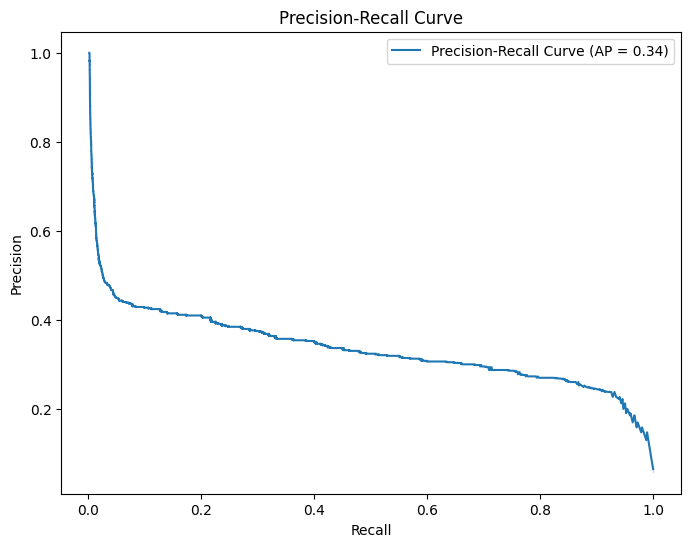

In [218]:
test_loss, y_true, y_pred, prauc = eval(test_loader, model, loss_fn)

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# Plot precision-recall curve using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(x=precision, y=recall, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [219]:
prauc

0.3374461764996491

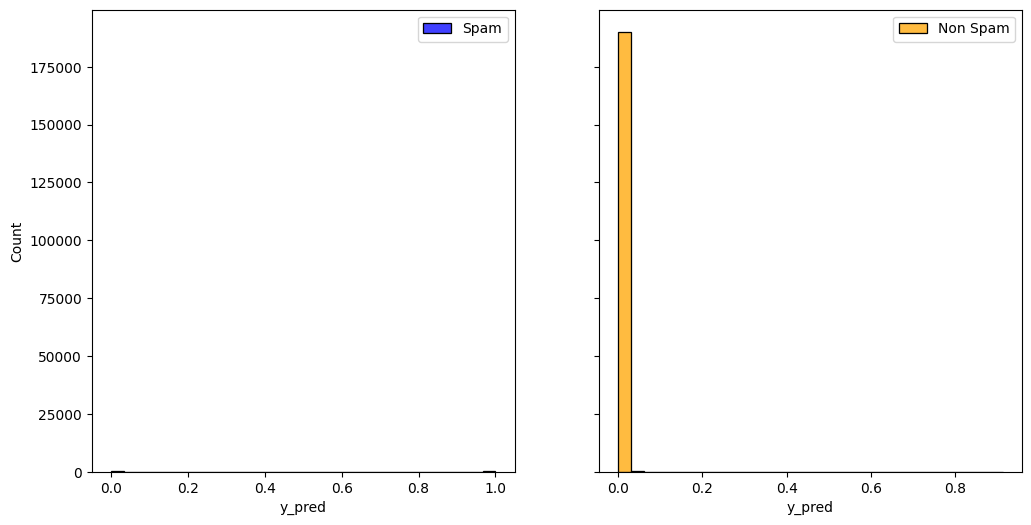

In [220]:
y_true_pred = pd.DataFrame({'y_true': y_true, 'y_pred': [x[0] for x in y_pred]})
# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the histograms side by side using Seaborn
sns.histplot(y_true_pred[y_true_pred['y_true'] == 1]['y_pred'], bins=30, ax=axes[0], color='blue', label='Spam')
sns.histplot(y_true_pred[y_true_pred['y_true'] == 0]['y_pred'], bins=30, ax=axes[1], color='orange', label='Non Spam')

# Add legend
axes[0].legend()
axes[1].legend()

# Show the plot
plt.show()

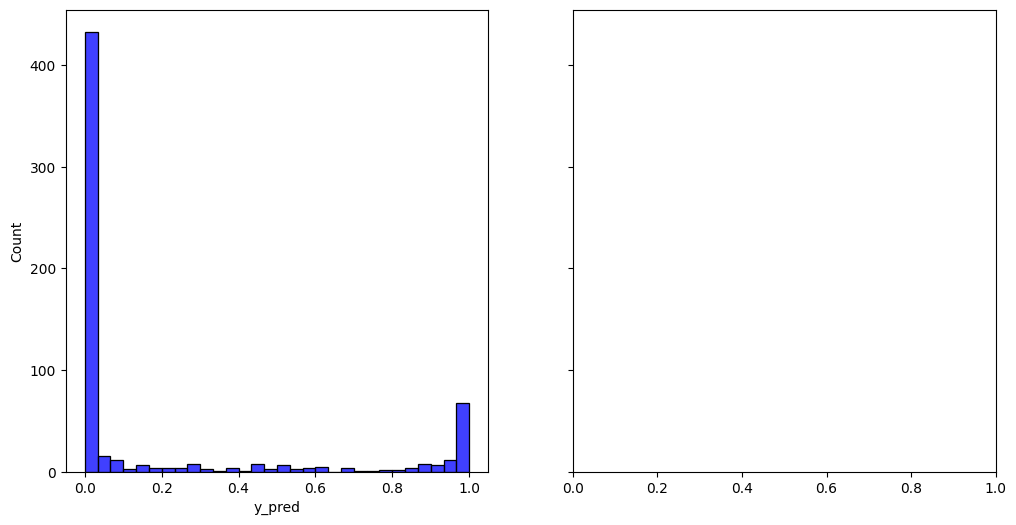

In [221]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sns.histplot(y_true_pred[y_true_pred['y_true'] == 1]['y_pred'], bins=30, ax=axes[0], color='blue', label='Spam')
plt.show()
